## 导入实验所需模块

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import platform
import sys
from six.moves import cPickle as pickle

In [3]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Activation
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from tensorflow.keras import backend as K

Using TensorFlow backend.


## 自定义加载数据函数

In [4]:
def load_batch(fpath, label_key='labels'):
    with open(fpath, 'rb') as f:
        if sys.version_info < (3,):
            d = pickle.load(f)
        else:
            d = pickle.load(f, encoding='bytes')
            # decode utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf8')] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]
 
    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

In [5]:
def load_data(ROOT):
    path = ROOT
    num_train_samples = 50000 
    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8') 
    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000: i * 10000, :, :, :],
         y_train[(i - 1) * 10000: i * 10000]) = load_batch(fpath)
 
    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath) 
    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))
    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1) 
    return (x_train, y_train), (x_test, y_test)

## 加载数据

In [6]:
(X_train, y_train), (X_test, y_test) = load_data('./dataset')

## 查看数据形状、类型

In [7]:
print(X_train.shape,y_train.shape)
print(type(X_train),type(y_train))

(50000, 32, 32, 3) (50000, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## 查看前十张图片

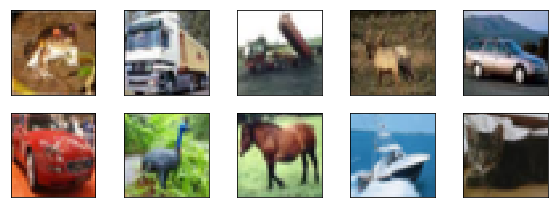

In [8]:
fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
    
plt.tight_layout()

## 选择所有的汽车图片

In [9]:
idx = np.where(y_train[:]==1)[0]
X_train = X_train[idx,::]

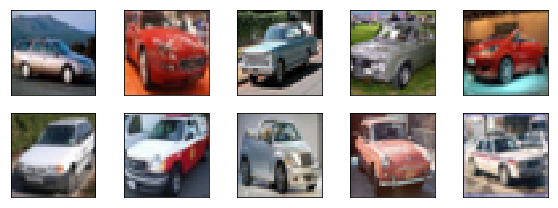

In [10]:
fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
    
plt.tight_layout()

## 图片预处理

In [11]:
num_classes = 10
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = c.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# 将标签转化为热编码形式（后续未使用到）
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# 将图像每一位像素设定在[-1,1]之间（为了使用tanh函数）
X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

## 定义生成器

In [12]:
# 噪声z初始维度
latent_dim = 100
#权重初始化为均值为0，标准差为0.02的正态分布
init = initializers.RandomNormal(stddev=0.02)

# 开始建立生成网络
generator = Sequential()

# 第一层使用全连接，其余层使用微步幅度卷积、批处理
# 最后一层使用tanhx激活函数，其余层均使用RuLu激活函数

# 1x100 ——> 2x2x512
generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((2, 2, 512)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))
# 2x2x512 ——> 4x4x256
generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))
# 4x4x256 ——> 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))
# 8x8x128 ——> 16x16x64
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))
# 6x16x64 ——> 32x32x3
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same'))
#generator.add(BatchNormalization())
generator.add(Activation('tanh'))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# 查看判别网络细节
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 256)         0         
__________

## 定义判别器

In [14]:
# 判别器输入图像的形状
img_shape = X_train[0].shape

# 开始建立判别网络
discriminator = Sequential()
#使用步幅卷积代替池化层
#除最后一层使用使用sigmoid激活函数，其余层均使用LeakyRelu函数作为激活函数

# 32x32x3 ——> 16x16x64
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                         input_shape=(img_shape), kernel_initializer=init))
#discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
# 16x16x64 ——> 8x8x128
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
# 8x8x128 ——> 4x4x256
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
# 4x4x256 ——> 2x2x512
discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
# 2x2x512 ——> 2048
discriminator.add(Flatten())
# 输出使用FC，为一维
discriminator.add(Dense(1, activation='sigmoid'))

In [15]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 256)         1024      
__________

## 判别器优化器，形成最优的D

In [16]:
# 优化器:Adam优化器，学习率0.0002，动量0.5
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

## 连接生成器和判别器，构建DCGAN网络

In [17]:
discriminator.trainable = False
z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

In [18]:
# DCGAN网络细节
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         4516739   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 4312193   
Total params: 8,828,932
Trainable params: 4,514,819
Non-trainable params: 4,314,113
_________________________________________________________________


## DCGAN优化器，形成最优的G

In [19]:
d_g.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

## 训练

Instructions for updating:
Use tf.cast instead.
epoch = 1/300, d_loss=0.251, g_loss=5.588                                                                                                                     


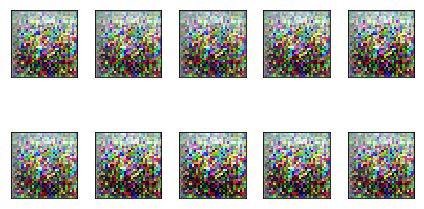

epoch = 2/300, d_loss=0.423, g_loss=0.678                                                                                                                    
epoch = 3/300, d_loss=0.553, g_loss=5.460                                                                                                                    
epoch = 4/300, d_loss=0.426, g_loss=6.315                                                                                                                    
epoch = 5/300, d_loss=0.270, g_loss=4.494                                                                                                                     
epoch = 6/300, d_loss=0.384, g_loss=2.693                                                                                                                    
epoch = 7/300, d_loss=0.206, g_loss=0.168                                                                                                                    
epoch = 8/300, d_loss=0.260, g_loss=4.275          

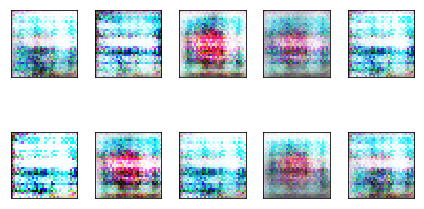

epoch = 12/300, d_loss=0.174, g_loss=0.095                                                                                                                    
epoch = 13/300, d_loss=0.188, g_loss=0.273                                                                                                                     
epoch = 14/300, d_loss=0.244, g_loss=0.247                                                                                                                     
epoch = 15/300, d_loss=0.215, g_loss=0.381                                                                                                                    
epoch = 16/300, d_loss=0.255, g_loss=1.541                                                                                                                    
epoch = 17/300, d_loss=0.220, g_loss=1.407                                                                                                                    
epoch = 18/300, d_loss=0.221, g_loss=4.749  

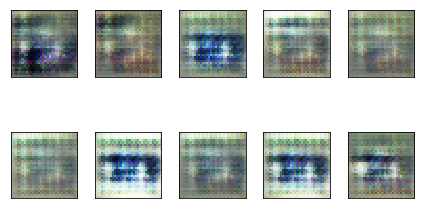

epoch = 22/300, d_loss=0.174, g_loss=0.028                                                                                                                    
epoch = 23/300, d_loss=0.203, g_loss=0.090                                                                                                                    
epoch = 24/300, d_loss=0.373, g_loss=1.765                                                                                                                     
epoch = 25/300, d_loss=0.262, g_loss=0.994                                                                                                                    
epoch = 26/300, d_loss=0.931, g_loss=12.679                                                                                                                    
epoch = 27/300, d_loss=0.474, g_loss=6.219                                                                                                                     
epoch = 28/300, d_loss=1.031, g_loss=1.809 

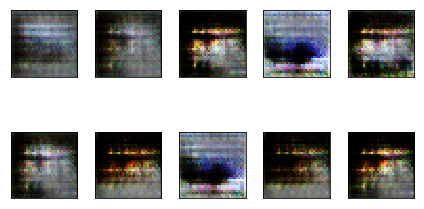

epoch = 32/300, d_loss=0.403, g_loss=1.835                                                                                                                     
epoch = 33/300, d_loss=0.576, g_loss=8.141                                                                                                                    
epoch = 34/300, d_loss=0.279, g_loss=4.506                                                                                                                     
epoch = 35/300, d_loss=0.180, g_loss=0.115                                                                                                                    
epoch = 36/300, d_loss=0.287, g_loss=7.269                                                                                                                    
epoch = 37/300, d_loss=0.204, g_loss=1.941                                                                                                                    
epoch = 38/300, d_loss=0.218, g_loss=5.103  

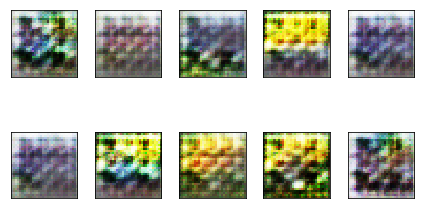

epoch = 42/300, d_loss=0.207, g_loss=6.609                                                                                                                    
epoch = 43/300, d_loss=0.251, g_loss=4.983                                                                                                                     
epoch = 44/300, d_loss=0.211, g_loss=2.696                                                                                                                    
epoch = 45/300, d_loss=0.180, g_loss=9.205                                                                                                                     
epoch = 46/300, d_loss=0.249, g_loss=2.282                                                                                                                     
epoch = 47/300, d_loss=0.174, g_loss=0.520                                                                                                                    
epoch = 48/300, d_loss=0.336, g_loss=1.444 

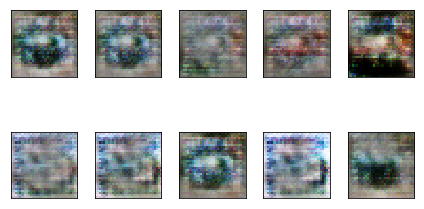

epoch = 52/300, d_loss=0.183, g_loss=0.081                                                                                                                    
epoch = 53/300, d_loss=0.182, g_loss=0.219                                                                                                                    
epoch = 54/300, d_loss=0.245, g_loss=7.467                                                                                                                     
epoch = 55/300, d_loss=0.213, g_loss=0.413                                                                                                                    
epoch = 56/300, d_loss=0.489, g_loss=2.105                                                                                                                    
epoch = 57/300, d_loss=0.326, g_loss=1.524                                                                                                                    
epoch = 58/300, d_loss=0.179, g_loss=0.137   

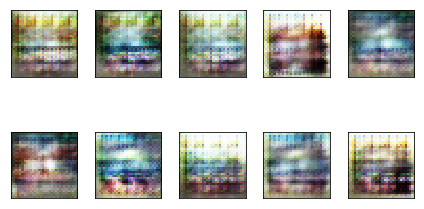

epoch = 62/300, d_loss=0.169, g_loss=0.061                                                                                                                    
epoch = 63/300, d_loss=0.169, g_loss=0.103                                                                                                                    
epoch = 64/300, d_loss=0.181, g_loss=9.282                                                                                                                     
epoch = 65/300, d_loss=0.206, g_loss=5.710                                                                                                                     
epoch = 66/300, d_loss=0.184, g_loss=0.938                                                                                                                    
epoch = 67/300, d_loss=0.176, g_loss=0.190                                                                                                                    
epoch = 68/300, d_loss=0.176, g_loss=0.151  

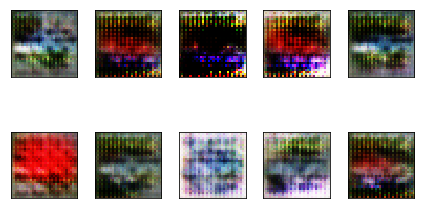

epoch = 72/300, d_loss=0.174, g_loss=0.265                                                                                                                    
epoch = 73/300, d_loss=0.192, g_loss=4.284                                                                                                                    
epoch = 74/300, d_loss=0.183, g_loss=2.021                                                                                                                    
epoch = 75/300, d_loss=0.220, g_loss=1.390                                                                                                                    
epoch = 76/300, d_loss=0.224, g_loss=2.051                                                                                                                     
epoch = 77/300, d_loss=0.400, g_loss=5.773                                                                                                                    
epoch = 78/300, d_loss=0.185, g_loss=0.156   

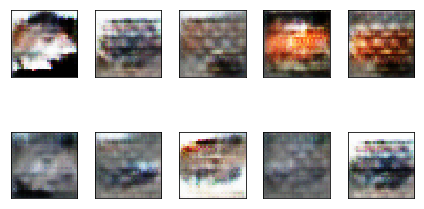

epoch = 82/300, d_loss=0.194, g_loss=0.303                                                                                                                    
epoch = 83/300, d_loss=0.231, g_loss=3.438                                                                                                                     
epoch = 84/300, d_loss=0.221, g_loss=7.104                                                                                                                    
epoch = 85/300, d_loss=0.210, g_loss=0.914                                                                                                                     
epoch = 86/300, d_loss=0.175, g_loss=0.156                                                                                                                    
epoch = 87/300, d_loss=0.168, g_loss=0.106                                                                                                                    
epoch = 88/300, d_loss=0.172, g_loss=0.124  

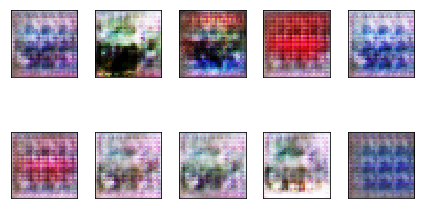

epoch = 92/300, d_loss=0.172, g_loss=0.101                                                                                                                    
epoch = 93/300, d_loss=0.186, g_loss=0.081                                                                                                                    
epoch = 94/300, d_loss=0.255, g_loss=2.816                                                                                                                     
epoch = 95/300, d_loss=0.214, g_loss=3.119                                                                                                                     
epoch = 96/300, d_loss=0.353, g_loss=0.793                                                                                                                     
epoch = 97/300, d_loss=0.190, g_loss=3.535                                                                                                                    
epoch = 98/300, d_loss=0.189, g_loss=0.062 

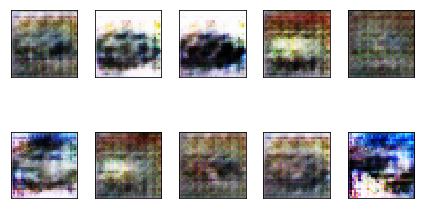

epoch = 102/300, d_loss=0.202, g_loss=4.575                                                                                                                     
epoch = 103/300, d_loss=0.169, g_loss=0.300                                                                                                                    
epoch = 104/300, d_loss=0.195, g_loss=3.325                                                                                                                    
epoch = 105/300, d_loss=0.261, g_loss=10.778                                                                                                                    
epoch = 106/300, d_loss=0.182, g_loss=0.181                                                                                                                     
epoch = 107/300, d_loss=0.196, g_loss=0.100                                                                                                                     
epoch = 108/300, d_loss=0.200, g_los

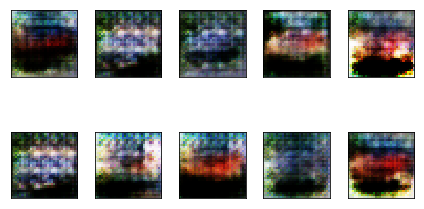

epoch = 112/300, d_loss=0.238, g_loss=1.369                                                                                                                    
epoch = 113/300, d_loss=0.169, g_loss=0.730                                                                                                                    
epoch = 114/300, d_loss=0.167, g_loss=0.528                                                                                                                    
epoch = 115/300, d_loss=0.170, g_loss=0.082                                                                                                                    
epoch = 116/300, d_loss=0.168, g_loss=0.060                                                                                                                    
epoch = 117/300, d_loss=0.166, g_loss=0.058                                                                                                                    
epoch = 118/300, d_loss=0.166, g_loss=0.

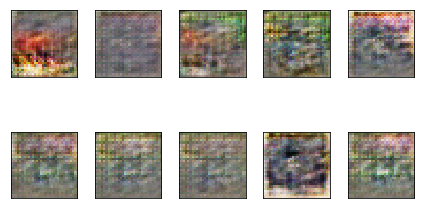

epoch = 122/300, d_loss=0.164, g_loss=0.033                                                                                                                    
epoch = 123/300, d_loss=0.165, g_loss=0.023                                                                                                                    
epoch = 124/300, d_loss=0.165, g_loss=0.045                                                                                                                    
epoch = 125/300, d_loss=0.252, g_loss=2.860                                                                                                                     
epoch = 126/300, d_loss=0.324, g_loss=3.792                                                                                                                    
epoch = 127/300, d_loss=0.562, g_loss=6.219                                                                                                                     
epoch = 128/300, d_loss=0.209, g_loss=

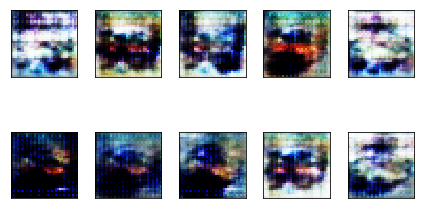

epoch = 132/300, d_loss=0.166, g_loss=0.147                                                                                                                    
epoch = 133/300, d_loss=0.165, g_loss=0.097                                                                                                                    
epoch = 134/300, d_loss=0.167, g_loss=0.071                                                                                                                    
epoch = 135/300, d_loss=0.171, g_loss=0.197                                                                                                                    
epoch = 136/300, d_loss=0.167, g_loss=0.061                                                                                                                    
epoch = 137/300, d_loss=0.165, g_loss=0.069                                                                                                                    
epoch = 138/300, d_loss=0.165, g_loss=0.

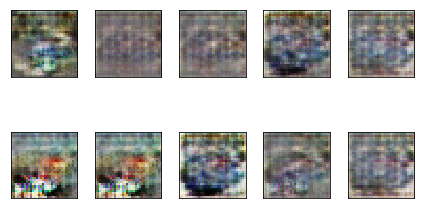

epoch = 142/300, d_loss=0.165, g_loss=0.062                                                                                                                    
epoch = 143/300, d_loss=0.347, g_loss=3.051                                                                                                                     
epoch = 144/300, d_loss=0.202, g_loss=0.213                                                                                                                     
epoch = 145/300, d_loss=1.009, g_loss=1.079                                                                                                                     
epoch = 146/300, d_loss=0.177, g_loss=0.091                                                                                                                    
epoch = 147/300, d_loss=0.202, g_loss=0.373                                                                                                                    
epoch = 148/300, d_loss=0.166, g_loss

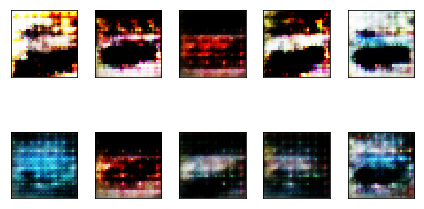

epoch = 152/300, d_loss=0.215, g_loss=1.251                                                                                                                    
epoch = 153/300, d_loss=0.166, g_loss=0.302                                                                                                                    
epoch = 154/300, d_loss=0.165, g_loss=0.860                                                                                                                    
epoch = 155/300, d_loss=0.197, g_loss=3.041                                                                                                                    
epoch = 156/300, d_loss=0.168, g_loss=0.122                                                                                                                    
epoch = 157/300, d_loss=0.165, g_loss=0.065                                                                                                                    
epoch = 158/300, d_loss=0.166, g_loss=0.

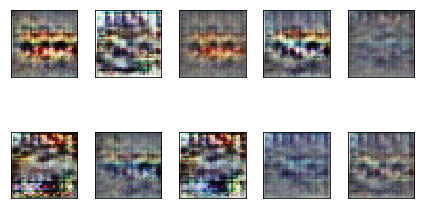

epoch = 162/300, d_loss=0.274, g_loss=3.299                                                                                                                     
epoch = 163/300, d_loss=0.176, g_loss=0.925                                                                                                                    
epoch = 164/300, d_loss=0.170, g_loss=3.807                                                                                                                    
epoch = 165/300, d_loss=0.221, g_loss=2.249                                                                                                                    
epoch = 166/300, d_loss=0.266, g_loss=6.830                                                                                                                    
epoch = 167/300, d_loss=0.208, g_loss=4.354                                                                                                                     
epoch = 168/300, d_loss=0.210, g_loss=

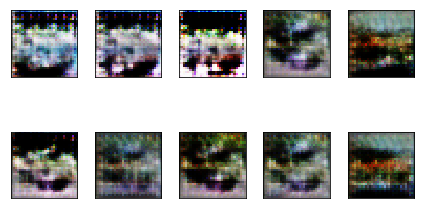

epoch = 172/300, d_loss=0.168, g_loss=0.309                                                                                                                    
epoch = 173/300, d_loss=0.197, g_loss=0.496                                                                                                                     
epoch = 174/300, d_loss=0.173, g_loss=0.092                                                                                                                     
epoch = 175/300, d_loss=0.168, g_loss=0.288                                                                                                                    
epoch = 176/300, d_loss=0.224, g_loss=2.810                                                                                                                    
epoch = 177/300, d_loss=0.217, g_loss=2.171                                                                                                                    
epoch = 178/300, d_loss=0.179, g_loss=

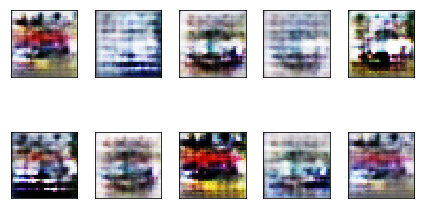

epoch = 182/300, d_loss=0.192, g_loss=0.234                                                                                                                     
epoch = 183/300, d_loss=0.169, g_loss=0.164                                                                                                                    
epoch = 184/300, d_loss=0.192, g_loss=2.145                                                                                                                    
epoch = 185/300, d_loss=0.492, g_loss=14.093                                                                                                                    
epoch = 186/300, d_loss=0.172, g_loss=0.358                                                                                                                    
epoch = 187/300, d_loss=0.171, g_loss=0.245                                                                                                                    
epoch = 188/300, d_loss=0.168, g_loss=

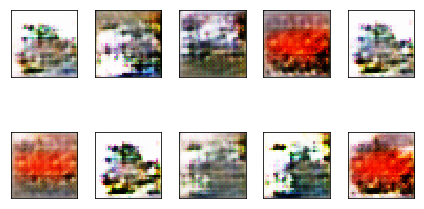

epoch = 192/300, d_loss=0.177, g_loss=0.132                                                                                                                    
epoch = 193/300, d_loss=0.173, g_loss=0.282                                                                                                                    
epoch = 194/300, d_loss=0.170, g_loss=0.182                                                                                                                    
epoch = 195/300, d_loss=0.175, g_loss=0.101                                                                                                                    
epoch = 196/300, d_loss=0.245, g_loss=4.165                                                                                                                     
epoch = 197/300, d_loss=0.246, g_loss=1.010                                                                                                                     
epoch = 198/300, d_loss=0.171, g_loss=

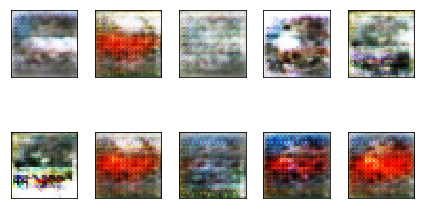

epoch = 202/300, d_loss=0.188, g_loss=6.277                                                                                                                     
epoch = 203/300, d_loss=0.180, g_loss=0.030                                                                                                                    
epoch = 204/300, d_loss=0.188, g_loss=0.628                                                                                                                    
epoch = 205/300, d_loss=0.265, g_loss=3.563                                                                                                                    
epoch = 206/300, d_loss=0.283, g_loss=1.944                                                                                                                     
epoch = 207/300, d_loss=0.260, g_loss=0.612                                                                                                                    
epoch = 208/300, d_loss=0.211, g_loss=

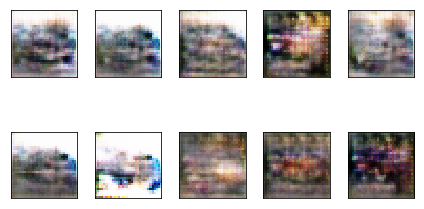

epoch = 212/300, d_loss=0.334, g_loss=3.263                                                                                                                     
epoch = 213/300, d_loss=0.215, g_loss=3.135                                                                                                                     
epoch = 214/300, d_loss=0.175, g_loss=0.827                                                                                                                    
epoch = 215/300, d_loss=0.174, g_loss=0.295                                                                                                                    
epoch = 216/300, d_loss=0.171, g_loss=0.336                                                                                                                    
epoch = 217/300, d_loss=0.173, g_loss=0.386                                                                                                                    
epoch = 218/300, d_loss=0.202, g_loss=

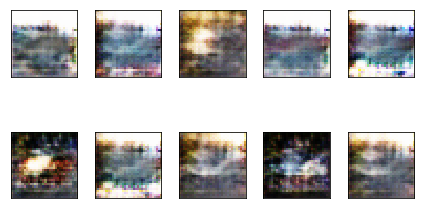

epoch = 222/300, d_loss=0.226, g_loss=3.917                                                                                                                     
epoch = 223/300, d_loss=0.348, g_loss=1.926                                                                                                                    
epoch = 224/300, d_loss=0.176, g_loss=0.416                                                                                                                    
epoch = 225/300, d_loss=0.184, g_loss=4.621                                                                                                                     
epoch = 226/300, d_loss=0.169, g_loss=0.228                                                                                                                    
epoch = 227/300, d_loss=0.248, g_loss=2.645                                                                                                                    
epoch = 228/300, d_loss=0.189, g_loss=

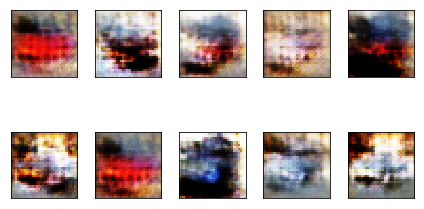

epoch = 232/300, d_loss=0.216, g_loss=0.628                                                                                                                    
epoch = 233/300, d_loss=0.201, g_loss=0.110                                                                                                                    
epoch = 234/300, d_loss=0.168, g_loss=0.083                                                                                                                    
epoch = 235/300, d_loss=0.169, g_loss=0.076                                                                                                                    
epoch = 236/300, d_loss=0.168, g_loss=0.053                                                                                                                    
epoch = 237/300, d_loss=0.176, g_loss=6.492                                                                                                                     
epoch = 238/300, d_loss=0.189, g_loss=0

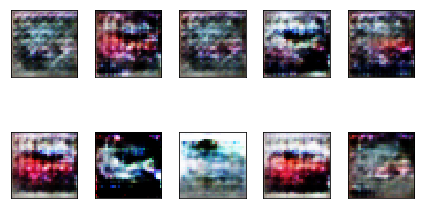

epoch = 242/300, d_loss=0.206, g_loss=2.884                                                                                                                     
epoch = 243/300, d_loss=0.247, g_loss=2.937                                                                                                                    
epoch = 244/300, d_loss=0.175, g_loss=0.218                                                                                                                    
epoch = 245/300, d_loss=0.173, g_loss=1.560                                                                                                                    
epoch = 246/300, d_loss=0.178, g_loss=0.783                                                                                                                     
epoch = 247/300, d_loss=0.233, g_loss=3.438                                                                                                                     
epoch = 248/300, d_loss=0.261, g_loss

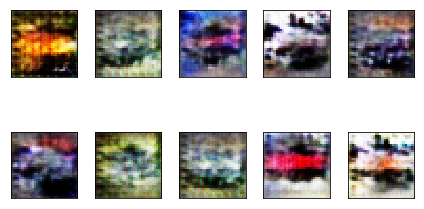

epoch = 252/300, d_loss=0.239, g_loss=2.239                                                                                                                     
epoch = 253/300, d_loss=0.260, g_loss=1.554                                                                                                                    
epoch = 254/300, d_loss=0.283, g_loss=5.054                                                                                                                    
epoch = 255/300, d_loss=0.187, g_loss=4.786                                                                                                                    
epoch = 256/300, d_loss=0.225, g_loss=4.520                                                                                                                     
epoch = 257/300, d_loss=0.230, g_loss=2.859                                                                                                                    
epoch = 258/300, d_loss=0.273, g_loss=

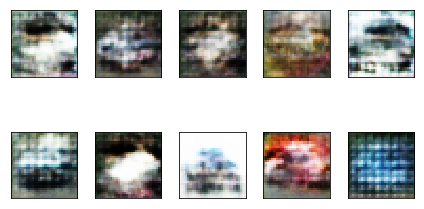

epoch = 262/300, d_loss=0.182, g_loss=0.823                                                                                                                     
epoch = 263/300, d_loss=0.186, g_loss=3.223                                                                                                                     
epoch = 264/300, d_loss=0.346, g_loss=0.766                                                                                                                    
epoch = 265/300, d_loss=0.203, g_loss=0.568                                                                                                                    
epoch = 266/300, d_loss=0.196, g_loss=0.867                                                                                                                    
epoch = 267/300, d_loss=0.178, g_loss=2.544                                                                                                                     
epoch = 268/300, d_loss=0.175, g_loss

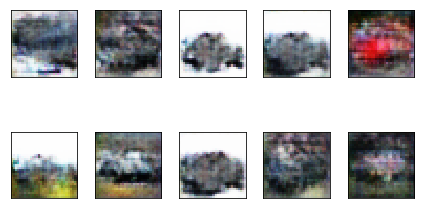

epoch = 272/300, d_loss=0.173, g_loss=0.115                                                                                                                    
epoch = 273/300, d_loss=0.171, g_loss=0.256                                                                                                                    
epoch = 274/300, d_loss=0.176, g_loss=0.351                                                                                                                    
epoch = 275/300, d_loss=0.271, g_loss=2.131                                                                                                                     
epoch = 276/300, d_loss=0.338, g_loss=0.508                                                                                                                    
epoch = 277/300, d_loss=0.290, g_loss=1.597                                                                                                                    
epoch = 278/300, d_loss=0.202, g_loss=0

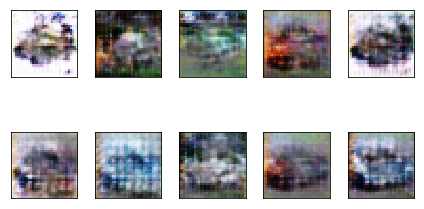

epoch = 282/300, d_loss=0.208, g_loss=6.777                                                                                                                     
epoch = 283/300, d_loss=0.590, g_loss=0.055                                                                                                                    
epoch = 284/300, d_loss=0.262, g_loss=4.468                                                                                                                    
epoch = 285/300, d_loss=0.329, g_loss=6.860                                                                                                                    
epoch = 286/300, d_loss=0.412, g_loss=2.138                                                                                                                     
epoch = 287/300, d_loss=0.226, g_loss=4.544                                                                                                                     
epoch = 288/300, d_loss=0.266, g_loss

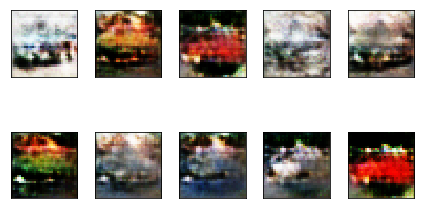

epoch = 292/300, d_loss=0.189, g_loss=3.755                                                                                                                     
epoch = 293/300, d_loss=0.179, g_loss=2.046                                                                                                                    
epoch = 294/300, d_loss=0.257, g_loss=3.135                                                                                                                     
epoch = 295/300, d_loss=0.198, g_loss=2.559                                                                                                                    
epoch = 296/300, d_loss=0.190, g_loss=1.409                                                                                                                    
epoch = 297/300, d_loss=0.218, g_loss=1.717                                                                                                                    
epoch = 298/300, d_loss=0.221, g_loss=

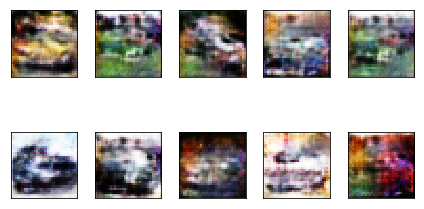

In [20]:
# 训练轮次
epochs = 300
# 每批数量
batch_size = 128
# 查阅资料发现设置smooth参数会有较好的效果
smooth = 0.1
# G训练时使得D(G(z))为real
# D训练时使得D(G(z))为fake，D(X_train[i])为real
real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))
# 用来存储生成器和判别器的损失
d_loss = []
g_loss = []
# 开始训练
for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):        
        
        # 训练判别器
        discriminator.trainable = True        
        # 输入真实数据，期望结果为real
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,y=real * (1 - smooth))       
        # 输入生成器生成的数据，期望结果为fake
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
        # 判别器损失，之后与生成器损失放在同一图中，便于观察乘以系数 0.5
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # 训练DCGAN（即生成器）
        discriminator.trainable = False
        # 输入生成器生成的数据，期望结果为real
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()

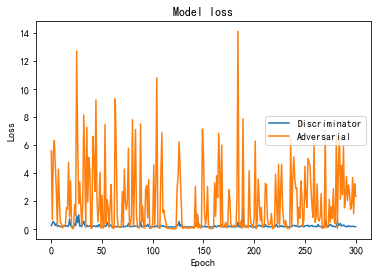

In [21]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()